> # Cats and Dogs Image Recognition 

In this homework we created two ways of image classification of dogs and cats images. This notebook present the use of building CNN from scratch and using VGG16 model with transfer learning.


## groundwork
downloading and extracting the images

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip


import os
import shutil
import zipfile

from numba import cuda
cuda.select_device(0)
cuda.close()

# removing is exists
if os.path.exists(os.path.join("/tmp" , "cats_and_dogs_filtered")):
  shutil.rmtree(os.path.join("/tmp" , "cats_and_dogs_filtered"))

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

# changing the name of the validation folder to test
os.rename(src=os.path.join("/tmp" , "cats_and_dogs_filtered" , "validation") , dst=os.path.join("/tmp" , "cats_and_dogs_filtered" , "test"))
filterd_dir_path = os.path.join("/tmp" , "cats_and_dogs_filtered")


--2023-01-09 21:52:52--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.163.128, 142.251.16.128, 172.253.62.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.163.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   198MB/s    in 0.3s    

2023-01-09 21:52:53 (198 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



## The ModelUse() class

This class handle all the model creation and fitting of the CNN and VGG, and help up change a lot of things in the structures of the neural network with using the same function. The main methods are:

1. `crate_image_gens()` - creating the ImageDataGenerators for the image flows from the filtered directory.
2. `genarate_model()` - creating the model structure and compiling it.
3. `arrange_by_tags()` - split the data from a given source folder to the correct folder format (split to train and test and inside them to the tags). we will use it in the final project.
4. `predict_image_with_cnn()` - using the CNN model that we have build to make a prediction. build for softmax and sigmoid and showing defferent prints to each one.
5. `cnn_model()` - creating a model fit if the `.h5` of this model name does not exists. if it is exists, loading the model.
6. `print_model_history_data()` - the history of the model fit method saved into `self.history` variable. this method takes this variable and display all its componnts.


In [2]:
from re import A
import os
import zipfile
from shutil import copy , rmtree
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from keras.utils import load_img , img_to_array
from keras import layers
from keras import Model
from keras.optimizers import RMSprop , SGD
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import random
from keras.applications import VGG16
from keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping



class ModelUse():
        def __init__(
                self,

                
                prediction_keys : list, # list of the tags this model know
                filtered_dir : str,
                data_src_dir : str = None, # source directory of the image data files
                 # destination directory of the image files
                train_split_size : int = None, # how many image going to the train data
                rearange_data : bool = True, # use only for the first time to transfer from the source to the destination dirs
                image_input_shape = (150,150,3),
                target_size = (150,150),
                output_activation : str = 'softmax',
                show_logs : bool = True, # manage the logs along the way
                use_padding : str = "valid",
                use_strides = (1,1),

                use_aug : bool = False,
                rotation_range : float = 30,
                width_shift_range : float =0.2,
                height_shift_range : float =0.2,
                zoom_range : float =0.2,
                horizontal_flip : bool = True,


                # neural network settings
                k_size : int = 3,
                conv2_act_func : list = ["relu" , "relu" , "relu"],
                conv2_node_number : list = [16 , 32 , 64],


                use_dropout : bool = False, # decide if you want to add dropout layer
                dropout_rate : float = 0.5, # if there is a dropout layer, decide the dropout rate

                optimizer = None, # the funciton that get send to the compile of the model
                learning_rate : float = 0.001,
                loss_function : any = 'binary_crossentropy',
                train_batch_size : int = 20,
                test_batch_size : int = 20,
                image_class_mode : str = 'categorical',
                existing_model_path = None, # is there is a model in a .h5 file, we can load it instead of creating NN again
                epoch_number : int = 10, 
                verbose : int = 2, # logs of the apoch proccess

                model_name : str = "my_model", # the name of the new modle that saved ( my_model.h5 )
                
                create_cnn : bool = True,
                create_vgg : bool = True,
                save_model : bool = False,

                
        ):
                
                try:
                        self.existing_model_path = os.path.join(os.getcwd() , existing_model_path)
                except:
                        self.existing_model_path = None
                self.rearange_data = rearange_data
                prediction_keys.sort()
                self.prediction_keys = prediction_keys
                self.data_dict = {}
                for key in self.prediction_keys:
                        self.data_dict[key] = []
                self.image_input_shape = image_input_shape
                self.output_activation = output_activation
                self.show_log = show_logs
                self.use_padding = use_padding
                self.use_strides = use_strides 

                self.use_aug = use_aug
                self.rotation_range = rotation_range 
                self.width_shift_range = width_shift_range
                self.height_shift_range = height_shift_range
                self.zoom_range = zoom_range
                self.horizontal_flip = horizontal_flip


                self.k_size = k_size
                self.conv2_act_function = conv2_act_func
                self.conv2_node_number = conv2_node_number

                self.use_dropout = use_dropout
                self.dropout_rate = dropout_rate

                self.learning_rate = learning_rate
                if optimizer == None:
                        self.use_optimizer = RMSprop(learning_rate=learning_rate)
                else:
                        self.use_optimizer = optimizer
                self.loss_function = loss_function
                self.epoch_number = epoch_number
                self.data_src_dir = data_src_dir
                self.filtered_dir = filtered_dir
                self.train_split_size = train_split_size
                self.image_target_size = target_size # i.e. 150X150 (150,150)
                self.train_batch_size = train_batch_size
                self.test_batch_size = test_batch_size
                self.image_class_mode = image_class_mode
                self.verbose = verbose

                self.save_model = save_model

                if create_cnn:
                  self.model_name = model_name
                  self.model = self.cnn_model()

                if create_vgg:
                  try:
                          self.vgg_tl_model = self.vgg16_transfer_learning_model()
                  except Exception as e:
                          print("Something went wrong with building the vgg model" , e) # 


        def create_image_gens(self , rescale_factor = 1./255 , datagen_mean : any = False , target_size = False):

                train_dir = os.path.join(self.filtered_dir , "train")
                test_dir = os.path.join(self.filtered_dir , "test")

                if not os.path.exists(train_dir) or not os.path.exists(test_dir):
                        return


                # All images will be rescaled by 1./255
                if self.use_aug:
                  train_datagen = ImageDataGenerator(rescale=rescale_factor,
                                                     rotation_range=self.rotation_range,
                                                      width_shift_range=self.width_shift_range,
                                                      height_shift_range=self.height_shift_range,
                                                      zoom_range=self.zoom_range,
                                                      horizontal_flip=self.horizontal_flip)
                  
                  test_datagen = ImageDataGenerator(rescale=rescale_factor)

                else:
                  train_datagen = ImageDataGenerator(rescale=rescale_factor)
                  test_datagen = ImageDataGenerator(rescale=rescale_factor)


                if datagen_mean:
                        train_datagen.mean = datagen_mean
                        test_datagen.mean = datagen_mean



                  
                if target_size:
                  # Flow training images in batches of 20 using train_datagen generator
                  train_gen = train_datagen.flow_from_directory(
                          train_dir,  # This is the source directory for training images
                          target_size=target_size,  # All images will be resized to 150x150
                          batch_size=self.train_batch_size,
                          class_mode=self.image_class_mode
                          )


                  # Flow validation images in batches of 20 using val_datagen generator
                  test_gen = test_datagen.flow_from_directory(
                          test_dir,
                          target_size=target_size,
                          batch_size=self.test_batch_size,
                          class_mode=self.image_class_mode
                          )

                else:
                  # Flow training images in batches of 20 using train_datagen generator
                  train_gen = train_datagen.flow_from_directory(
                          train_dir,  # This is the source directory for training images
                          target_size=self.image_target_size,  # All images will be resized to 150x150
                          batch_size=self.train_batch_size,
                          class_mode=self.image_class_mode
                          )


                  # Flow validation images in batches of 20 using val_datagen generator
                  test_gen = test_datagen.flow_from_directory(
                          test_dir,
                          target_size=self.image_target_size,
                          batch_size=self.test_batch_size,
                          class_mode=self.image_class_mode
                          )

                return train_gen , test_gen

        def genarate_model(self):
                """
                  This method define the NN structure
                """ 
                # Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
                # the three color channels: R, G, and B
                img_input = layers.Input(shape=self.image_input_shape)

                first = True
                # This loop use two lists of values to create the layers in this model
                # in a dynamic way, by adding Conv2D layer and MaxPool layer according to 
                # current activation function and number of nodes given in the lists
                for act_func , node_number in zip(self.conv2_act_function , self.conv2_node_number):
                        if first:        
                                x = layers.Conv2D(node_number, self.k_size, activation=act_func , padding = self.use_padding)(img_input)
                                first = False
                        else:
                                x = layers.Conv2D(node_number, self.k_size, activation=act_func)(x)                
                        x = layers.MaxPooling2D(2)(x)
                        

                # Flatten feature map to a 1-dim tensor so we can add fully connected layers
                x = layers.Flatten()(x)

                # Create a fully connected layer with ReLU activation and 512 hidden units
                x = layers.Dense(512, activation='relu')(x)

                if self.use_dropout:
                        x = layers.Dropout(self.dropout_rate)(x)
                
                
                if self.output_activation == "sigmoid":
                        output_lenght = 1
                elif self.output_activation == "softmax":
                        output_lenght = len(self.prediction_keys)
                
                output = layers.Dense(output_lenght , activation=self.output_activation)(x)

                # Create model:
                # input = input feature map
                # output = input feature map + stacked convolution/maxpooling layers + fully 
                # connected layer + sigmoid output layer
                model = Model(img_input, output)

                if self.show_log:
                        model.summary()

                model.compile(loss=self.loss_function ,optimizer=self.use_optimizer , metrics=['acc'])

                self.model = model
                return model

        def arrange_by_tags(self):
        
                if os.path.exists(self.filtered_dir):
                        rmtree(self.filtered_dir)

                os.mkdir(self.filtered_dir)
                os.mkdir(os.path.join(self.filtered_dir , "train"))
                os.mkdir(os.path.join(self.filtered_dir , "test"))
                

                img_file_list = os.listdir(self.data_src_dir)

                for img in img_file_list:
                        for key in list(self.data_dict.keys()):
                                if key in img:
                                        self.data_dict[key].append(img)


                train_images = {}
                test_images = {}

                if self.train_split_size == None:
                        # half of the size of the min length
                        length_of_data_list = [len(self.data_dict[key]) for key in list(self.data_dict.keys())]
                        self.train_split_size = round(min(length_of_data_list)/2)



                for key in list(self.data_dict.keys()):
                        train_images[key] = self.data_dict[key][:self.train_split_size]
                        test_images[key] = self.data_dict[key][self.train_split_size:]


                # copy the files from the source dir to the filtered dir
                for key in list(train_images.keys()):

                        # copy all the train files from the source dir to the filtered dir
                        for filename in train_images[key]:

                                if not os.path.exists(f"{self.filtered_dir}\\train\\{key}"):
                                        path = os.path.join(f"{self.filtered_dir}\\train", key)
                                        
                                        os.mkdir(path)

                                copy(f"{self.data_src_dir}\\{filename}" , f"{self.filtered_dir}\\train\\{key}\\{filename}")
                        
                        # copy all the test files from the source dir to the filtered dir
                        for filename in test_images[key]:
                                if not os.path.exists(f"{self.filtered_dir}/test/{key}"):
                                        os.mkdir(f"{self.filtered_dir}/test/{key}")

                                copy(f"{self.data_src_dir}/{filename}" , f"{self.filtered_dir}/test/{key}/{filename}")

                # print the length of all the files for a certain tag
                if self.show_log:
                        for key in list(self.data_dict.keys()):
                                print(f"list length of {key} : " , len(self.data_dict[key]))
                 
        def predict_image_with_cnn(self ,  img_path  , model = None ):

                if model==None:
                        model = self.model
                
                img = load_img(img_path, target_size=self.image_target_size)  
                x = img_to_array(img)  
                x = x.reshape((1,) + x.shape)

                # Rescale by 1/255
                x /= 255

                # Let's run our image through our network, thus obtaining all
                # intermediate representations for this image.
                successive_feature_maps = model.predict(x)
                
                if len(successive_feature_maps[0]) == 1:
                  return successive_feature_maps[0]
                
                pred_dict = {}

                for key , pred in zip(self.prediction_keys , successive_feature_maps[0]):
                        pred_dict[key] = pred
                

                return pred_dict

        def predict_image_with_vgg(self, image_path , model = None):
                pass

        def cnn_model(self): 

                model_filename = os.path.join(os.getcwd() , ".".join([self.model_name , "h5"])) 
                if os.path.exists(model_filename):
                        print("Loading model from  " , model_filename)
                        self.model = load_model(model_filename)
                        return self.model
                        
                        
                print(f"Creating new model at {model_filename}...")


                if self.rearange_data:
                        self.arrange_by_tags()

                # dumb model
                our_model = self.genarate_model()
                
                # create generators
                train_generator , test_generator = self.create_image_gens()

                # training the model
                 
                self.history = our_model.fit(
                        train_generator,
                        epochs=self.epoch_number,
                        validation_data=test_generator,
                        verbose=self.verbose
                )

                if self.save_model:
                  try:
                          print("Saving new model to " , model_filename )
                          our_model.save(model_filename)
                          self.existing_model_path = model_filename
                                  
                  except Exception as e:
                          print(e)

        
                self.model = our_model
                return our_model
                      
        def print_model_history_data(self):
                
                try:
                  # Retrieve a list of accuracy results on training and validation data
                  # sets for each training epoch
                  acc = self.history.history['acc']
                  val_acc = self.history.history['val_acc']

                  # Retrieve a list of list results on training and validation data
                  # sets for each training epoch
                  loss = self.history.history['loss']
                  val_loss = self.history.history['val_loss']

                  # Get number of epochs
                  epochs = range(len(acc))

                  # Plot training and validation accuracy per epoch
                  plt.plot(epochs, acc)
                  plt.plot(epochs, val_acc)
                  plt.title('Training and validation accuracy')

                  plt.figure()

                  # Plot training and validation loss per epoch
                  plt.plot(epochs, loss)
                  plt.plot(epochs, val_loss)
                  plt.title('Training and validation loss')

                  last_apoch_acc = acc[-1]
                  last_apoch_val_acc = val_acc[-1]
                  return last_apoch_acc , last_apoch_val_acc
                except:
                  _ , test_gen = self.create_image_gens()
                  loss , acc = self.model.evaluate(test_gen)
                  return acc , acc 
                  

        def vgg16_transfer_learning_model(self):

                # load model
                model = VGG16(include_top=False, input_shape=(224, 224, 3))
                
                # mark loaded layers as not trainable
                for layer in model.layers:
                        layer.trainable = False


                # add new classifier layers
                x = layers.Flatten()(model.layers[-1].output)
                x = layers.Dense(50, activation=self.output_activation, kernel_initializer='he_uniform')(x)
                x = layers.Dense(20, activation=self.output_activation)(x)

                if self.use_dropout:
                  x = layers.Dropout(self.dropout_rate)(x)

                output = layers.Dense(1, activation=self.output_activation)(x)
                

                # define new model
                model = Model(inputs=model.inputs, outputs=output)

                # compile model
                model.compile(optimizer=self.use_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

                if self.show_log:
                  print(model.summary())

                train_generator , test_generator = self.create_image_gens(datagen_mean=[123.68, 116.779, 103.939] ,target_size=(224,224))

                
                es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)


                self.history = model.fit(train_generator, 
                                         steps_per_epoch=len(train_generator), 
                                         validation_data = test_generator , 
                                         epochs=self.epoch_number, 
                                         verbose=self.verbose,
                                         callbacks=[es],
                                         )

                self.vgg_tl_model = model

                return model





# Finding the best CNN 

From now we are going to use the `ModelUse` class to configure our models.

## 1. Finding the best batch size

Using a loop we will go through all the options:
```
batch_size_list = [4,128,512,1024]
```

Also, for all the checks we are saving the `max_vall_acc` and the `best_model_name` that we found.

In [4]:

batch_size_list = [4,128,512,1024]
max_acc = 0
max_val_acc = 0
best_batch_size = batch_size_list[0]

best_model_name = ""

for bs in batch_size_list:
    
  cat_dog_use = ModelUse(
      
      # data_src_dir=os.path.join(os.getcwd() , "hw\data_mining_project\image_iden\weather"),
      filtered_dir=filterd_dir_path,
      rearange_data=False,
      prediction_keys = ["cat" , "dog"],
      model_name=f"Model_Batch_{bs}",
      conv2_act_func=["relu","relu","relu"],
      image_input_shape=(150,150,3),
      show_logs = True,
      output_activation="sigmoid",
      test_batch_size=bs,
      optimizer=SGD(learning_rate=0.001, momentum=0.9),
      epoch_number=10,
      verbose=0,
      image_class_mode="binary",

      create_vgg = False,

  )

  
  cur_acc , cur_val_acc = cat_dog_use.print_model_history_data()
  print(f"{cat_dog_use.model_name} acc : {cur_acc} , val_acc : {cur_val_acc}")

  if cur_val_acc > max_val_acc:
      max_val_acc = cur_val_acc
      best_batch_size = bs

      best_model_name = cat_dog_use.model_name



print(f"Best Model : {best_model_name}")


Creating new model at /content/Model_Batch_4.h5...
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_

KeyboardInterrupt: ignored

## 2. Finding with or without pading

Now, we are checking for the `best_batch_size` but with padding. By setting the `use_padding` argument to `"same"`, we are implamenting the padding in the new model. We are also showing the logs (`model.summary`) to show that the padding is implamented.

After the check for new `max_val_acc` we will save the `padding_settings` to set the next check with this check's results ("same" or "valid").

Creating new model at /content/Model_Batch_1024_wp.h5...
Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_24 (Conv2D)          (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 75, 75, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 73, 73, 32)        4640      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 

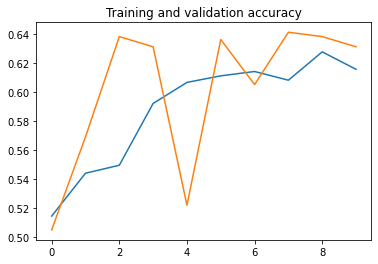

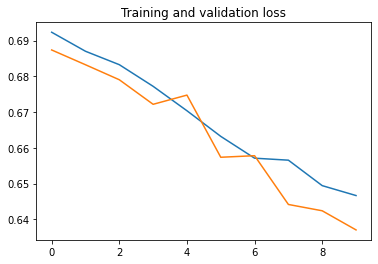

In [ ]:

cat_dog_use = ModelUse(
    
    # data_src_dir=os.path.join(os.getcwd() , "hw\data_mining_project\image_iden\weather"),
    filtered_dir=filterd_dir_path,
    rearange_data=False,
    prediction_keys = ["cat" , "dog"],
    model_name=best_model_name + "_wp",
  
    conv2_act_func=["relu","relu","relu"],
    image_input_shape=(150,150,3),
    show_logs = True,
    output_activation="sigmoid",
    test_batch_size=best_batch_size,
    optimizer=SGD(learning_rate=0.001, momentum=0.9),
    epoch_number=10,
    verbose=0,
    image_class_mode="binary",
    use_padding="same",

)

cur_acc , cur_val_acc = cat_dog_use.print_model_history_data()
print(f"{cat_dog_use.model_name} acc : {cur_acc} , val_acc : {cur_val_acc}")

if cur_val_acc > max_val_acc:
  max_val_acc = cur_val_acc
  best_model_name = cat_dog_use.model_name
  padding_settings = "same"
else:
  padding_settings = "valid"


print(f"Best Model : {best_model_name}")



## 3. Check with or without dropout

By setting the `use_dropout` argument in the of the class, we are telling the `generate_model` method to now add the Dropout layer.

We use the same trick of saving the `dropout_settings` (True or False) to send it to the next test, after we get the results if the dropout was helpful or not.

The default value for the dropout rate is set to:
```python
dropout_rate : float = 0.5, # if there is a dropout layer, decide the dropout rate

```

Creating new model at /content/Model_Batch_1024_wdo.h5...
Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_27 (Conv2D)          (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 74, 74, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 


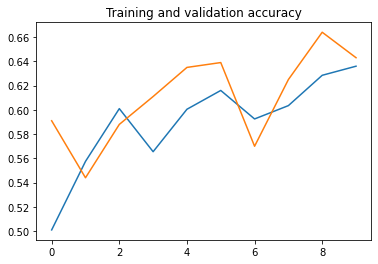

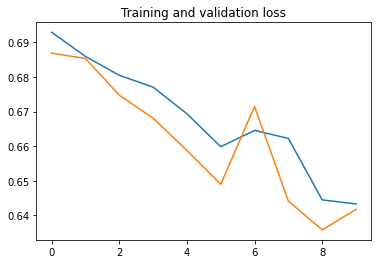

In [ ]:


cat_dog_use = ModelUse(
    
    filtered_dir=filterd_dir_path,
    rearange_data=False,
    prediction_keys = ["cat" , "dog"],
    model_name = best_model_name + "_wdo",
    conv2_act_func=["relu","relu","relu"],
    image_input_shape=(150,150,3),
    show_logs = True,
    output_activation="sigmoid",
    test_batch_size=bs,
    optimizer=SGD(learning_rate=0.001, momentum=0.9),
    epoch_number=10,
    verbose=2,
    image_class_mode="binary",
    use_padding=padding_settings,
    use_dropout=True,

)


cur_acc , cur_val_acc = cat_dog_use.print_model_history_data()
print(f"{cat_dog_use.model_name} acc : {cur_acc} , val_acc : {cur_val_acc}")

if cur_val_acc > max_val_acc:
  max_val_acc = cur_val_acc
  best_model_name = cat_dog_use.model_name
  dropout_settings = True
else:
  dropout_settings = False

print(f"Best Model : {best_model_name}")

## 4. with or without augmentations

The last test. We are setting the `use_aug` to True for now add the augmentations. The default augmentations is set inside the `__init__` method of the class, used in the `crate_image_gens` method and has default values of:

```python
    rotation_range : float = 30,
    width_shift_range : float =0.2,
    height_shift_range : float =0.2,
    zoom_range : float =0.2,
    horizontal_flip : bool = True,
``` 

the default values can be sent to the class with this arguments.


In [ ]:


cat_dog_use = ModelUse(
    
    filtered_dir=filterd_dir_path,
    rearange_data=False,
    prediction_keys = ["cat" , "dog"],
    model_name = best_model_name + "_wdo",
    # train_split_size=150,
    conv2_act_func=["relu","relu","relu"],
    image_input_shape=(150,150,3),
    show_logs = True,
    output_activation="sigmoid",
    test_batch_size=bs,
    optimizer=SGD(learning_rate=0.001, momentum=0.9),
    epoch_number=10,
    verbose=2,
    image_class_mode="binary",
    use_padding=padding_settings,
    use_dropout=dropout_settings,
    use_aug=True,
    create_vgg=False,

)

cur_acc , cur_val_acc = cat_dog_use.print_model_history_data()

if cur_val_acc > max_val_acc:
  max_val_acc = cur_val_acc
  best_model_name = cat_dog_use.model_name



Loading model from   /content/Model_Batch_1024_wdo.h5
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/10
Something went wrong with building the vgg model
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 5s 5s/step - loss: 0.6417 - acc: 0.6430


In [ ]:
print(best_model_name)

Model_Batch_1024


## Using VGG16 with transfer learning

For this part, we used the VGG-16 model. By adding three of our own layers and train them separately, we can use the already trained model and add to its fetures.

In the next section of code, we are finding the best combination of attributes that with them we will get the best validation accuracy. By using the `ModelUse` class and creating a `config` dictionary, we can iterate all possible permutations of those configurations, to find the one with the max validation accuracy.




In [ ]:

from keras.optimizers import RMSprop , SGD
from datetime import datetime

cur_option = 1
max_val_acc = 0
best_config = {}

config = {
    
    "optimizer" : ["adam"],
    "epoch_number" : [10],
    "test_batch_size" : [20],

}


for opt in config["optimizer"]:
  for en in config["epoch_number"]:
    for bs in config["test_batch_size"]:

      
            
      model_name = "_".join(["vgg_transfer_learning", str(opt) ,str(en) ,str(bs)])
      print(model_name)
      
      print(f"{cur_option}. Opt : {opt} , epoch number : {en} , batch size : {bs}")
      
      cat_dog_use = ModelUse(
          

          filtered_dir=filterd_dir_path,
          rearange_data=False,
          prediction_keys = ["cat" , "dog"],
          image_input_shape=(150,150,3),
          show_logs = True,
          output_activation="sigmoid",
          
          image_class_mode="binary",
          use_padding=False,
          create_cnn=False,
          verbose=0,
          create_vgg=True,

          model_name = model_name,
          optimizer=opt,
          epoch_number=en,
          test_batch_size=bs,


      )

      try:
        h_data = cat_dog_use.history.history
        

        print(f"  acc : {h_data['accuracy'][-1]} , loss : {h_data['loss'][-1]} , val_acc : {h_data['val_accuracy'][-1]} , val_loss : {h_data['val_loss'][-1]}")
        cur_val_acc = h_data['val_accuracy'][-1]
        if cur_val_acc > max_val_acc:
          max_val_acc = cur_val_acc 
          best_config = {
              "option" : cur_option,
              "optimizer" : opt,
              "epoch_number" : en,
              "test_batch_size" : bs,
              "acc" : h_data['accuracy'][-1],
              "val_acc" : max_val_acc,
          }
      except:
        pass

      cur_option += 1



vgg_transfer_learning_adam_10_20
1. Opt : adam , epoch number : 10 , batch size : 20
Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                       